In [1]:
import numpy as np
from sklearn.metrics import jaccard_score
from collections import defaultdict
import json
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import sys
import random
from operator import itemgetter

In [15]:
import matplotlib.pyplot as plt

In [25]:
plt.style.use('ggplot')

In [2]:
data_path = '../data/cleaned/RC_2023-01_2.json'
with open(data_path, 'r') as fh:
    comments = json.load(fh)

### Simple Data Stats

In [4]:
print(f'No. of comments in the data - {len(comments)}')

No. of comments in the data - 314599


In [5]:
n_subreddit = len(set([comment['subreddit_id'] for comment in comments]))
print(f'No. of unique subreddits : {n_subreddit}')

No. of unique subreddits : 18645


In [6]:
n_users = len(set([comment['author'] for comment in comments]))
print(f'No. of unique users : {n_users}')

No. of unique users : 77996


### Leave One Out Splitting

In [87]:
## Utility Functions

def plot_comment_distribution(itemsperuser):
    count, frequency = np.unique([len(items) for user, items in itemsperuser.items()], return_counts=True)
    plt.bar(np.log(count), frequency)
    plt.show()

def get_item_by_idx_list(ls:list, idx:list):
    return list(itemgetter(*idx)(ls))

def get_users(comments:list, idx:list = None):
    users = set()
    if not (idx is None):
        comments = get_item_by_idx_list(comments, idx)
    for comment in comments:
        users.add(comment['author_fullname'])
    return users

def get_users_per_item(comments:list, idx:list = None):
    if not (idx is None):
        comments = get_item_by_idx_list(comments, idx)
    usersperitem = defaultdict(set)
    for comment in comments:
        user = comment['author_fullname']
        item = comment['subreddit_id']
        usersperitem[item].add(user)
    return usersperitem

def get_items_per_users(comments:list, idx:list = None):
    if not (idx is None):
        comments = get_item_by_idx_list(comments, idx)
    itemsperuser = defaultdict(set)
    for comment in comments:
        user = comment['author_fullname']
        item = comment['subreddit_id']
        itemsperuser[user].add(item)
    return itemsperuser

def get_item_map(comments):
    item_name = defaultdict(str)
    for comment in comments:
        item = comment['subreddit_id']
        item_name[item] = comment['subreddit']
    return item_name

def get_item_id(comments):
    pass

In [88]:
## Spliting Fucntion

def leave_one_out_split(comments: list):
    # authors = get_authors(data)
    author_idx = defaultdict(list)
    author_subreddit = defaultdict(set)
    train_idx, test_idx = [], []
    for i, comment in tqdm(enumerate(comments)):
        author = comment['author_fullname']
        subreddit = comment['subreddit_id']
        if subreddit not in author_subreddit[author]:
            author_subreddit[author].add(subreddit)
            author_idx[author].append(i)
    # print(author_idx[author])
    for author, _idx in tqdm(author_idx.items()):
        # print(_idx)
        if len(_idx) >= 2:
            train_idx.extend(_idx[:-1])
            test_idx.append(_idx[-1])
    return train_idx, test_idx

In [89]:
train_idx, test_idx = leave_one_out_split(comments=comments)
print(f'No. of training Samples - {len(train_idx)}')
print(f'No. of test samples - {len(test_idx)}')

314599it [00:00, 692992.65it/s]
100%|██████████| 77996/77996 [00:00<00:00, 1519682.14it/s]

No. of training Samples - 71210
No. of test samples - 41258


In [90]:
item_name = get_item_map(comments=comments)
users = get_users(comments)

In [91]:
itemsperuser = get_items_per_users(comments=comments)
usersperitem = get_users_per_item(comments=comments)

In [92]:
np.unique([len(items) for user, items in itemsperuser.items()], return_counts=True)[0]

array([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,
         23,   24,   25,   26,   27,   28,   29,   30,   32,   34,   35,
         38,   41,   42,   44,   52,   53,   58,   72,   73,   85,  147,
       2904])

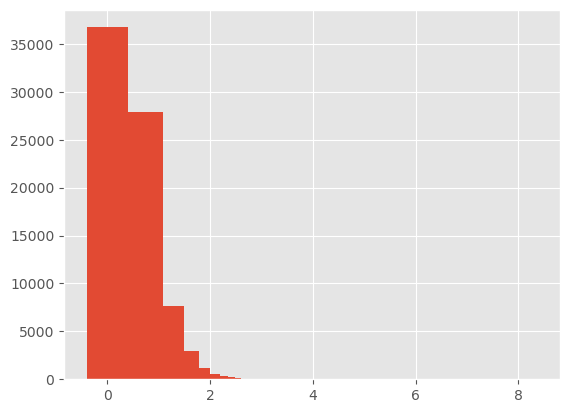

In [93]:
count, frequency = np.unique([len(items) for user, items in itemsperuser.items()], return_counts=True)
plt.bar(np.log(count), frequency)
plt.show()

In [94]:
itemsperuser_train = get_items_per_users(comments, idx = train_idx)
usersperitem_train = get_users_per_item(comments, idx=train_idx)

itemsperuser_test = get_items_per_users(comments, idx=test_idx)
usersperitem_test = get_users_per_item(comments, idx=test_idx)

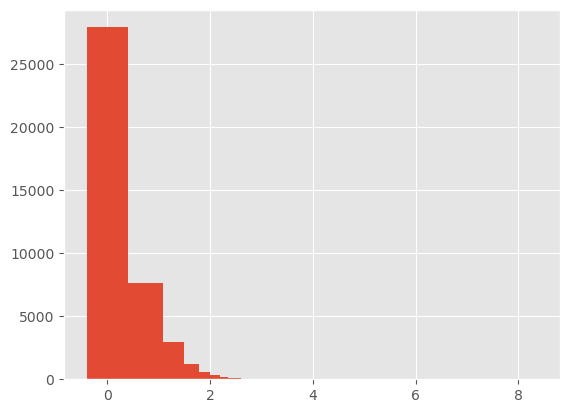

In [95]:
plot_comment_distribution(itemsperuser_train)

In [96]:
## Model Fucntion

def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

def score(u, itemHistory, itemsperuser):
    userHistory = itemsperuser[u]
    bestsim = None
    for v in itemHistory:
        if u == v:
            continue
        sim = Jaccard(userHistory, itemsperuser[v])
        if bestsim == None or sim > bestsim:
            bestsim = sim
    if bestsim == None:
        return 0
    return bestsim

def rec(u, itemsperuser, usersperitem):
    history = itemsperuser[u]
    bestitem = None
    bestscore = None
    for i in item_name:
        if i in history:
            continue
        s = score(u, usersperitem[i], itemsperuser)
        if bestitem == None or s > bestscore:
            bestitem = i
            bestscore = s
    return bestitem, bestscore

In [112]:
while True:
    u = random.sample(users, 1)[0]
    if len(itemsperuser_train[u]) > 3:
        break
item, similarity_score = rec(u, itemsperuser_train, usersperitem_train)
print(f'recommended - {item_name[item]}')
print('user history')
for item in itemsperuser_train[u]:
    print(item_name[item])

test_item = list(itemsperuser_test[u])[0]
print(f'test_set - {item_name[str(test_item)]}')

recommended - truerateme
user history
RoastMe
army
Rateme
amiugly
firstimpression
test_set - preppers


In [115]:
np.sum(np.array([1,2,3])== np.array([0,2,1]))

1

In [122]:
## naive evaluation function
def naive_eval(pred:list, true:list):
    return np.sum(np.array(pred)== np.array(true))/len(pred)

In [120]:
true, pred = [], []
random_users = get_item_by_idx_list(list(users), np.random.random_integers(low = 0, high = len(users), size = int(0.1*len(users))))
for u in tqdm(random_users):
    if np.random.random() < 0.5:
        continue
    if len(itemsperuser_train[u]) < 3:
        continue
    item, similarity_score = rec(u, itemsperuser_train, usersperitem_train)
    # print(f'recommended - {item_name[item]}')
    # print('user history')
    # for item in itemsperuser_train[u]:
    #     print(item_name[item])
    test_item = list(itemsperuser_test[u])[0]
    pred.append(item)
    true.append(test_item)

/tmp/ipykernel_3769352/3779637221.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 77996 + 1) instead
  random_users = get_item_by_idx_list(list(users), np.random.random_integers(low = 0, high = len(users), size = int(0.1*len(users))))
100%|██████████| 7799/7799 [01:44<00:00, 74.92it/s] 


In [128]:
naive_metric = naive_eval(pred, true)
print(f'The model predicted {naive_metric*100:,.2f}% queries correctly')

The model predicted 0.64% queries correctly
